In [1]:
#TaylorGreen2D
#Energy reporten (gibt verschiedene Möglichkeiten an die Daten zu kommen)
#Dissipation ist zeitliche Ableitung (numpy.gradient)
# ins Paper schauen, wie das definiert ist
# Vis über matplotlib
# welche Reynolds sind im Paper
#die hohen Re bekommt man hier nicht hin (speicher)
#geringe Auflösung bis 100-200

In [2]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

In [37]:
my_data = np.genfromtxt('Brache_TGVortex_ReferenzAusLettucePaper.csv', delimiter=',')

In [78]:
def run(collision,vtk=False):
    
    ##definiere Simulationsparameter

    lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=torch.float64)
    flow = lt.TaylorGreenVortex3D(resolution=64, reynolds_number=400, mach_number=0.05, lattice=lattice)
        #Kollisionsoperator: BGKCollision, MRTCollision, TRTCollision, RegularizedCollision, KBCCollision2D, KBCCollision3D, SmagorinskyCollision, BGKInitialization
    collision = collision(lattice, tau=flow.units.relaxation_parameter_lu)
    streaming = lt.StandardStreaming(lattice)
    simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)
    
    energy = lt.IncompressibleKineticEnergy(lattice, flow)
    simulation.reporters.append(lt.ObservableReporter(energy, interval=20,out=None))
    
    spectrum = lt.EnergySpectrum(lattice, flow)
    simulation.reporters.append(lt.ObservableReporter(spectrum, interval=int(flow.units.convert_time_to_lu(2.5))))
    
    if vtk:
        VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(0.1)), filename_base="./out")
        simulation.reporters.append(VTKreport)
        print("VTKreporter hinzugefügt")
        
    
    simulation.initialize_f_neq #zu t0 werden die Schermomente approximiert
    #am Anfang muss sich Reibung sonst erst einpendeln, so hat man aber schon einen besseren Start (insb. für schlecht aufgelöste Sim. und wichtige Sim.)
    
    print(int(flow.units.convert_time_to_lu(10)))
    
    mlups = simulation.step(num_steps=int(flow.units.convert_time_to_lu(10)))

    energy = np.array(simulation.reporters[0].out)
    
    return energy

In [79]:
energy_1 = run(lt.BGKCollision,vtk=False)

energy_2 = run(lt.RegularizedCollision)

energy_3 = run(lt.KBCCollision3D)

steps     time     IncompressibleKineticEnergy
VTKreporter hinzugefügt
3528
steps     time     IncompressibleKineticEnergy
3528
steps     time     IncompressibleKineticEnergy
3528


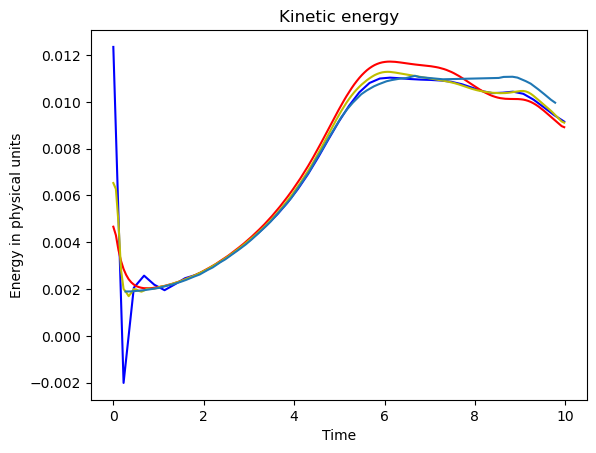

In [80]:
grad_ener1=-np.gradient(energy_1[:,2],energy_1[:,1])/((2*np.pi)**3)
grad_ener2=-np.gradient(energy_2[:,2],energy_2[:,1])/((2*np.pi)**3)
grad_ener3=-np.gradient(energy_3[:,2],energy_3[:,1])/((2*np.pi)**3)
#gradient: (f,t) -> gibt nur f'

plt.plot(energy_1[::4,1],grad_ener1[::4],'b')
plt.plot(energy_2[:,1],grad_ener2,'r')
plt.plot(energy_3[:,1],grad_ener3,'y')
plt.plot(my_data[:,0],my_data[:,1])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()